In [883]:
import attacker
import numpy as np
import opendp.smartnoise.core as sn
from sklearn.feature_selection import mutual_info_regression
from typing import List, Tuple
from scipy import stats as st
from numba import njit
from tqdm import tqdm
from matplotlib import pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import pickle
import re
import fbleau
import subprocess
from entropy_estimators import continuous

In [151]:
def fbleau_bayes_risk(trace, secret, output):
    data = np.array([trace[secret], trace[output]]).reshape(-1,2)
    tr=int(0.8*len(data[:,0]))
    data_train, data_test = data[:tr], data[tr:]
    train_secret = data_train[:,0].astype(np.Uint64)
    test_secret = data_test[:,0].astype(np.Uint64)
    res = fbleau.run_fbleau(data_train, train_secret, data_test, test_secret, estimate='knn',
                      knn_strategy='ln', distance='euclidean', log_errors=False,
                      log_individual_errors=False, delta=None, qstop=None,
                      absolute=False, scale=False)
    return res["min-estimate"]

# Average age evaluation with unknown Alice

In [440]:
def mean_float(a: List[float]) -> float:
    return np.mean(a)

domain = [
    {
        "name": "age",
        "lower": 10,
        "upper": 50,
        "type": "float",
        "alice": st.norm(25,15)
    }
]

def f(trace):
    I = mutual_info_regression(trace["Alice_age"].reshape(-1,1), 
                               trace["out"], 
                               discrete_features=False, 
                               random_state=np.random.RandomState(12345))[0]
    return -I

In [370]:
attacker.parameters.CONT_DIST = 3
q = mean_float
wrap = attacker.construct_analysis(q, 
                            domain, 
                            f,
                            cores=1)


  0%|          | 0/3 [2:15:10<?, ?it/s]5s/it]

100%|██████████| 3/3 [02:21<00:00, 47.15s/it]


In [237]:
print(min(wrap.Y[0]))
wrap.best_dist()

[-3.89873381]
[45.63981776  0.1       ]
Normal(mu=45.63981776407776, sigma=0.1)


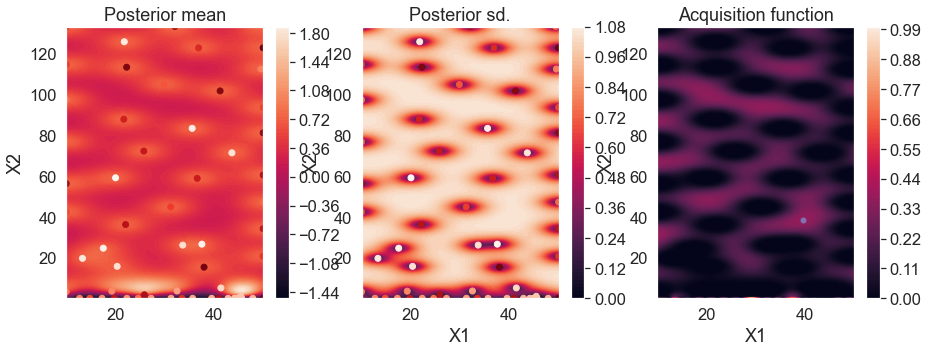

In [238]:
wrap.bos[0].plot_acquisition()

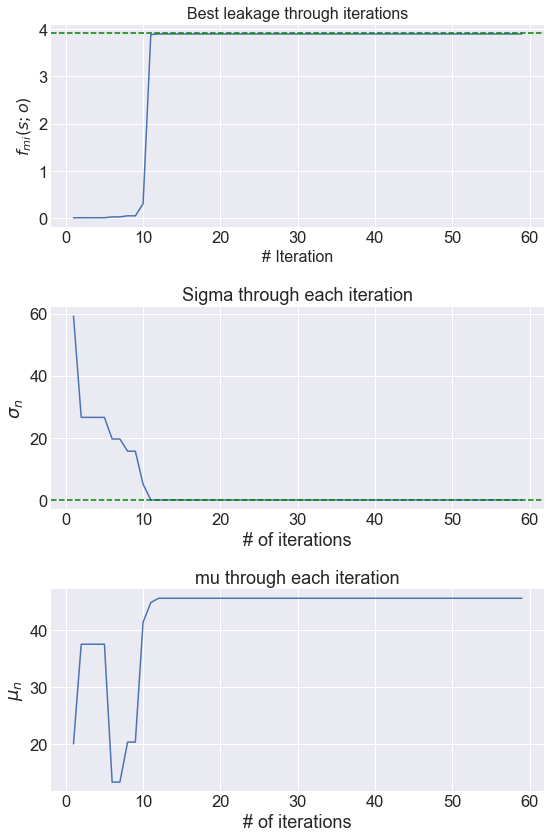

In [362]:
def fmi(X):
    res = (np.log(15*15+9*X**2)-np.log(9*X**2))/2
    return res

x = np.linspace(0.1,1/12*(40)**2, 1000)
y = [fmi(xi) for xi in x]

plt.style.use('seaborn-darkgrid')

siz = len(wrap.X[0])
best = -np.array([min(wrap.Y[0][:i]) for i in range(1,siz)])

best_val = np.array([wrap.X[0][np.argmin(wrap.Y[0][:i])] for i in range(1,siz)])
best_std = best_val[:,1]
best_mu = best_val[:,0]

x = np.arange(1,siz)
fig,ax = plt.subplots(3,1,figsize=(8,12))
ax[0].plot(x, best, "-")
ax[0].axhline(fmi(0.1), linestyle="--", color="green")
ax[0].set_xlabel("# Iteration", fontdict={"fontsize": 16})
ax[0].set_ylabel("$f_{mi}(s;o)$", fontdict={"fontsize": 16})
ax[0].set_title("Best leakage through iterations", fontdict={"fontsize": 16})

ax[1].plot(x, best_std)
ax[1].set_xlabel("# of iterations")
ax[1].set_ylabel("$\sigma_n$")
ax[1].axhline(0.1, linestyle="--", color="green")
ax[1].set_title("Sigma through each iteration")

ax[2].plot(x, best_mu)
ax[2].set_xlabel("# of iterations")
ax[2].set_ylabel("$\mu_n$")
ax[2].set_title("mu through each iteration")
plt.tight_layout()
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/normal_age_loss.png")

In [ ]:


x = np.linspace(10,50,1000)
samples = 10_000
s = st.norm(25,10).rvs(samples)
n = st.norm(26.48196,0.1).rvs(samples)
o = (s + sum([s for _ in range(9)]))/10

In [ ]:
sns.set(font_scale = 1.5)
dist = {"$s$": s, "$n$": n, "$o$": o}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.set(xlim=(10,50))
g.set(ylim=(10,50))
g.map_diag(sns.histplot, kde=True, discrete=False, color='orange', stat='density')
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/age-comparison2.png")

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(8,8))


ax[0,0].hist(s, )

for i in range(3):
    for j in range(3):
        ax[i,j].set_ylim(10,50)
        ax[i,j].set_xlim(10,50)

# Complex example

In [436]:
def q(a: List[int]) -> int:
    return sum(a)

domain = [
    {
        "name": "age",
        "lower": 10,
        "upper": 50,
        "type": "int"
    }
]

def f(trace):
    I = mutual_info_regression(trace["Alice_age"].reshape(-1,1), 
                               trace["out"], 
                               discrete_features=False, 
                               random_state=np.random.RandomState(12345))[0]
    return -I
attacker.parameters.CONT_DIST = 3
wrap2_disc = attacker.construct_analysis(q, 
                            domain, 
                            f,
                            cores=1)


100%|██████████| 2/2 [01:11<00:00, 35.70s/it]


In [437]:
wrap2_disc.best_dist()

[10. 25.]
Poisson(mu=10.0, scale=25.0)
[10.  1.]
Discrete Uniform(lower=10.0, scale=1.0)


In [ ]:
x = np.linspace(10,50,1000)
samples = 10_000
s = st.uniform(10,40).rvs(samples)
n = st.halfnorm(44.14,0.1).rvs(samples)
o = (s + sum([s for _ in range(9)]))/10

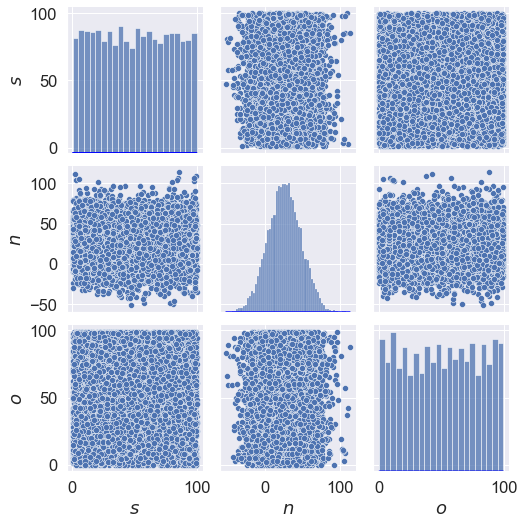

In [364]:
sns.set(font_scale = 1.5)
dist = {"$s$": s, "$n$": n, "$o$": o}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=True, discrete=False, color="blue", stat='density')
#plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/age-comparison-V2.png")

# Median age

In [2]:
def median_float(a: List[float]) -> float:
    res = np.median(a)
    return res

domain = [
    {
        "name": "age",
        "lower": 10,
        "upper": 50,
        "type": "float"
    }
]

def f(trace):
    I = mutual_info_regression(trace["Alice_age"].reshape(-1,1), 
                               trace["out"], 
                               discrete_features=False, 
                               random_state=np.random.RandomState(12345))[0]
    return -I
wrap3 = attacker.construct_analysis(q, 
                            domain, 
                            f,
                            cores=1)

100%|██████████| 3/3 [02:40<00:00, 53.47s/it]


In [76]:
# Store or load
x,y = wrap3.X, wrap3.Y
with open("/Users/maoj/Documents/Thesis/Thesis_code/Executions/median_age.privug", "wb") as fil:
    pickle.dump([x,y], fil)

In [5]:
I, trace = wrap3.functions[0]([wrap3.X[0][np.argmin(wrap3.Y[0])]],0, return_trace=True)

In [77]:
#load
with open("/Users/maoj/Documents/Thesis/Thesis_code/Executions/median_age.privug", "rb") as fil:
    x,y = pickle.load(fil)

In [15]:
wrap3.best_dist()

[ 32.34218408 121.34674696]
Normal(mu=32.34218408039794, sigma=121.34674696346039)
[10.31954913 39.68028761]
Uniform(lower=10.319549129410175, scale=39.68028760620317)
[16.40056475 12.76681411]
HalfNormal(mu=16.400564749264852, scale=12.766814111977645)


In [14]:
np.min(wrap3.Y, axis=1)

array([[-1.09250109],
       [-0.29903936],
       [-0.15854349]])

In [13]:
x = np.linspace(10,50,1000)
samples = 10_000
s = st.uniform(10,40).rvs(samples)
n = st.uniform(10.9,38.46)
db= [s if i == 0 else n.rvs(10_000) for i in range(10)]
o = np.array([np.median(v) for v in list(zip(*db))])
print(mutual_info_regression(trace["Alice_age"].reshape(-1,1), trace["out"], discrete_features=False))

[0.99661407]


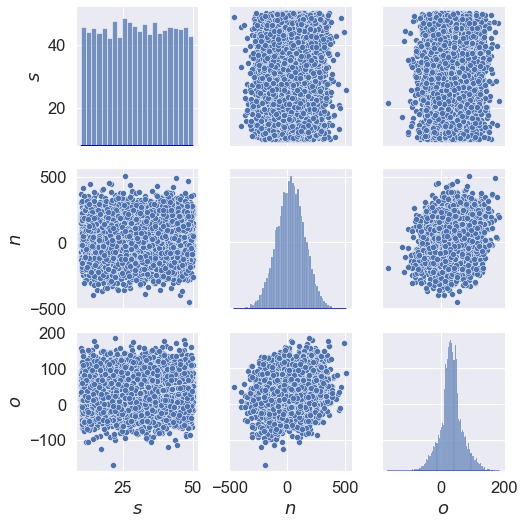

In [8]:
sns.set(font_scale = 1.5)
dist = {"$s$": trace["Alice_age"], "$n$": trace["Rest_age"][0], "$o$": trace["out"]}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=True, discrete=False, color="blue", stat='density')
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/age-comparison-median-V1.png")

# Average age with differential privacy

In [16]:
## opendp program
def dp_program(age: List[float]) -> float:
    temp_file='temp.csv'    
    var_names = ["age"]
    data = {
        "age":     age,
    }
    df = pd.DataFrame(data,columns=var_names)
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean of age
        age_mean = sn.dp_mean(data = sn.to_float(data['age']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 10., # min age
                              data_upper = 50., # max age                  
                              data_rows = 10
                             )
    analysis.release()
    return np.float64(age_mean.value)    

domain = [
    {
        "name": "age",
        "lower": 10,
        "upper": 50,
        "type": "float",
    }
]

def f(trace):
    I = mutual_info_regression(trace["Alice_age"].reshape(-1,1), 
                               trace["out"], 
                               discrete_features=False, 
                               random_state=np.random.RandomState(12345))[0]
    return -I

In [17]:
wrap4 = attacker.construct_analysis(dp_program, 
                            domain, 
                            f,
                            cores=1)

100%|██████████| 3/3 [1:51:04<00:00, 2221.67s/it]


In [18]:
wrap4.best_dist()

[32.16647329 87.4187868 ]
Normal(mu=32.16647328628589, sigma=87.41878680293381)
[10.88245837 18.47764311]
Uniform(lower=10.882458372664052, scale=18.477643114793445)
[19.53422379 14.65493658]
HalfNormal(mu=19.53422378853748, scale=14.654936579858104)


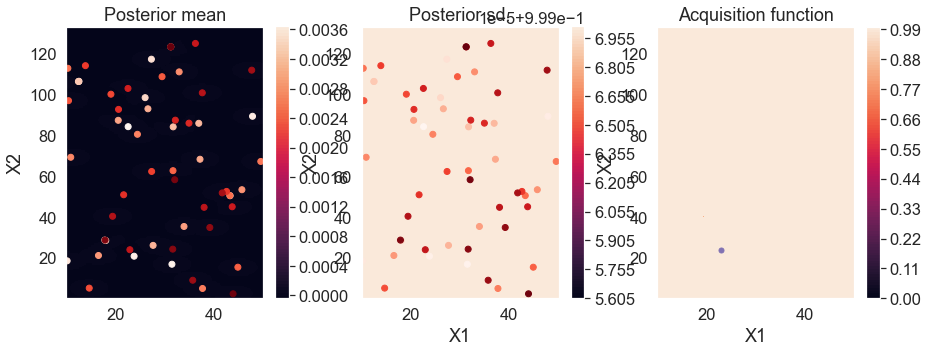

<Figure size 432x288 with 0 Axes>

In [597]:
wrap4.bos[0].plot_acquisition()


In [19]:
np.min(wrap4.Y, axis=1)

array([[-0.01126287],
       [-0.01458324],
       [-0.01170894]])

In [21]:
x,y = wrap4.X, wrap4.Y
with open("/Users/maoj/Documents/Thesis/Thesis_code/Executions/dp-average-age.privug", "wb") as fil:
    pickle.dump([x,y], fil)

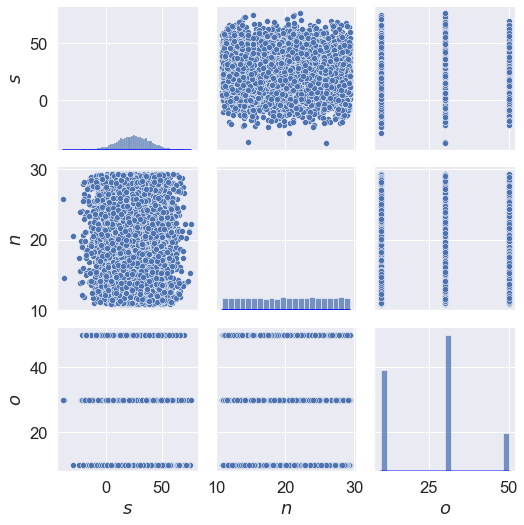

In [24]:
I, trace = wrap4.functions[1]([wrap4.X[1][np.argmin(wrap4.Y[1])]],1, return_trace=True)
sns.set(font_scale = 1.5)
dist = {"$s$": trace["Alice_age"], "$n$": trace["Rest_age"][0], "$o$": trace["out"]}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=True, discrete=False, color="blue", stat='density')
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/DP-age-v1.png")

# Unknown alice

In [604]:
## opendp program
def dp_program(a: float, b: float) -> float:
    temp_file='temp.csv'    
    var_names = ["age"]
    data = {
        "age":     [a,b],
    }
    df = pd.DataFrame(data,columns=var_names)
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean of age
        age_mean = sn.dp_mean(data = sn.to_float(data['age']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 10., # min age
                              data_upper = 50., # max age                  
                              data_rows = 2
                             )
    analysis.release()
    return np.float64(age_mean.value)    

domain = [
    {
        "name": "a",
        "lower": 10,
        "upper": 50,
        "type": "float"
    },     {
        "name": "b",
        "lower": 10,
        "upper": 50,
        "type": "float"
    }
]

def f(trace):
    I = mutual_info_regression(trace["Alice_a"].reshape(-1,1), 
                               trace["out"], 
                               discrete_features=False, 
                               random_state=np.random.RandomState(12345))[0]
    return -I

In [605]:
wrapDP = attacker.construct_analysis(dp_program, 
                            domain, 
                            f,
                            cores=1)




  0%|          | 0/9 [21:56<?, ?it/s]



 11%|█         | 1/9 [1:03:43<8:29:51, 3823.91s/it]


 22%|██▏       | 2/9 [2:03:35<7:10:12, 3687.52s/it]


 33%|███▎      | 3/9 [2:49:54<5:27:14, 3272.44s/it]


 44%|████▍     | 4/9 [3:37:20<4:18:41, 3104.22s/it]


 56%|█████▌    | 5/9 [4:23:27<3:18:50, 2982.53s/it]


 67%|██████▋   | 6/9 [5:10:03<2:25:57, 2919.24s/it]


 78%|███████▊  | 7/9 [5:57:09<1:36:16, 2888.49s/it]


 89%|████████▉ | 8/9 [6:50:59<49:57, 2997.31s/it]  


100%|██████████| 9/9 [7:33:16<00:00, 3021.86s/it]


In [606]:
wrapDP.best_dist()

[ 37.92901835  66.54237005  28.78308867 128.55853866]
Normal(mu=37.929018347441755, sigma=66.54237004596503)
[ 37.92901835  66.54237005  28.78308867 128.55853866]
Normal(mu=37.929018347441755, sigma=66.54237004596503)
[10.69079571 31.06528793 25.10542963 13.66998453]
Normal(mu=10.690795712999197, sigma=31.065287928796234)
[10.69079571 31.06528793 25.10542963 13.66998453]
Uniform(lower=10.690795712999197, scale=31.065287928796234)
[23.3559114  91.43536999 22.28631183 12.23158663]
Normal(mu=23.355911397698538, sigma=91.43536998765799)
[23.3559114  91.43536999 22.28631183 12.23158663]
HalfNormal(mu=23.355911397698538, scale=91.43536998765799)
[ 45.53680821   1.89224053  26.99083563 126.91895417]
Uniform(lower=45.536808213241535, scale=1.8922405292613975)
[ 45.53680821   1.89224053  26.99083563 126.91895417]
Normal(mu=45.536808213241535, sigma=1.8922405292613975)
[16.78126389 29.25603332 16.31349495 11.21791947]
Uniform(lower=16.781263892821222, scale=29.25603331806771)
[16.78126389 29.256

In [610]:
np.min(wrapDP.Y, axis=1)

array([[-0.01524591],
       [-0.01343816],
       [-0.01074666],
       [-0.01353662],
       [-0.01042752],
       [-0.01385891],
       [-0.01263056],
       [-0.01476143],
       [-0.01105461]])

In [611]:
wrapDP.X[0][np.argmin(wrapDP.Y[0])]

array([ 37.92901835,  66.54237005,  28.78308867, 128.55853866])

In [620]:
s = st.norm(40,66.5423).rvs(10_000)
n = st.norm(28.783,128.558).rvs(10_000)
o = [dp_program(si, ni) for si, ni in tqdm(zip(s,n))]
mutual_info_regression(s.reshape(-1,1),o, discrete_features=False)

10000it [00:48, 206.77it/s]


array([0.01251984])

In [634]:
np.corrcoef(s,o)

array([[1.        , 0.00875769],
       [0.00875769, 1.        ]])

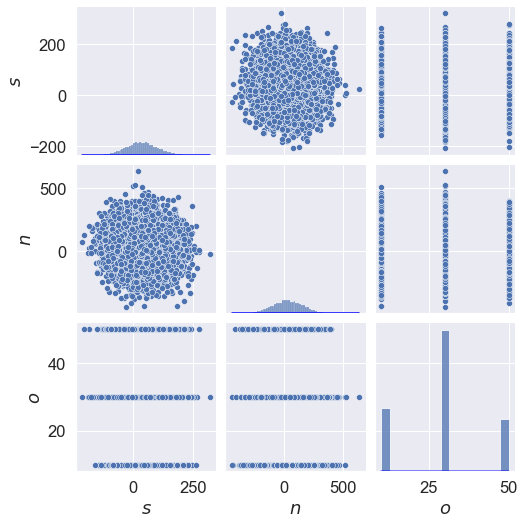

In [621]:
sns.set(font_scale = 1.5)
dist = {"$s$": s, "$n$": n, "$o$": o}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=True, discrete=False, color="blue", stat='density')
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/DP-age-v4.png")

<AxesSubplot:ylabel='Density'>

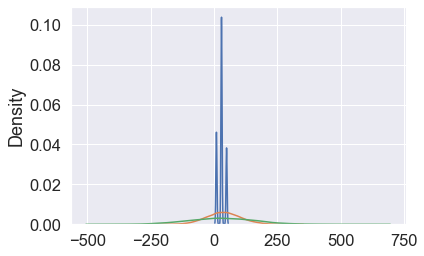

In [632]:
fig,ax = plt.subplots()
sns.kdeplot(o)
sns.kdeplot(s)
sns.kdeplot(n)

In [629]:
np.corrcoef(s,o)

array([[1.        , 0.00875769],
       [0.00875769, 1.        ]])

In [26]:
domain = [
    {
        "name": "age",
        "lower": 10,
        "upper": 50,
        "type": "float",
    }
]

def f(trace):
    I = mutual_info_regression(trace["Alice_age"].reshape(-1,1), 
                               trace["out"], 
                               discrete_features=False, 
                               random_state=np.random.RandomState(12345))[0]
    return -I
wrap5 = attacker.construct_analysis(dp_program, 
                            domain, 
                            f,
                            cores=1)
wrap5.best_dist()
print(np.min(wrap5.Y, axis=1))


100%|██████████| 3/3 [1:50:52<00:00, 2217.60s/it]

[32.06959231 61.19482076]
Normal(mu=32.069592307321244, sigma=61.19482075586766)
[10.58131075  3.24694637]
Uniform(lower=10.58131074891023, scale=3.2469463742740423)
[29.92656677  4.03235446]
HalfNormal(mu=29.92656677127701, scale=4.03235446005868)
[[-0.01136605]
 [-0.01046955]
 [-0.01713905]]


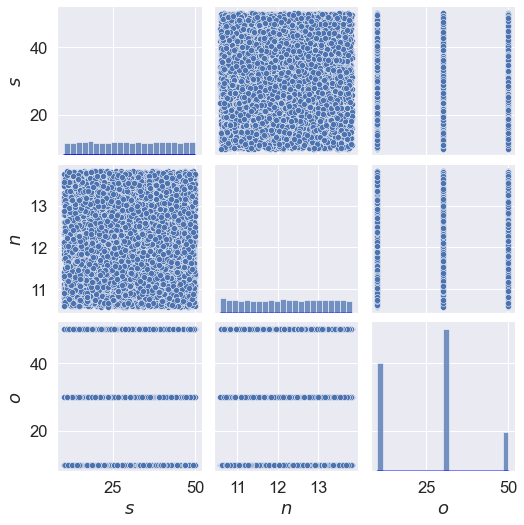

In [49]:
I, trace = wrap5.functions[1]([wrap5.X[1][np.argmin(wrap5.Y[1])]],1, return_trace=True)
sns.set(font_scale = 1.5)
dist = {"$s$": trace["Alice_age"], "$n$": trace["Rest_age"][0], "$o$": trace["out"]}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=True, discrete=False, color="blue", stat='density')
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/DP-age-v2.png")

In [28]:
x,y = wrap5.X, wrap4.Y
with open("/Users/maoj/Documents/Thesis/Thesis_code/Executions/dp-average-age.2.privug", "wb") as fil:
    pickle.dump([x,y], fil)

# Trying to optimize both for alice and other individuals:

In [45]:
def dp_program_full_opt(a: float, b: float) -> float:
    temp_file='temp.csv'    
    var_names = ["age"]
    l = np.array([a[0],b[0]])
    data = {
        "age":     l,
    }
    df = pd.DataFrame(data,columns=var_names)
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean of age
        age_mean = sn.dp_mean(data = sn.to_float(data['age']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 10., # min age
                              data_upper = 50., # max age                  
                              data_rows = 2
                             )
    analysis.release()
    return np.float64(age_mean.value)    

domain = [
    {
        "name": "a",
        "lower": 10,
        "upper": 50,
        "type": "float",
    },    {
        "name": "b",
        "lower": 10,
        "upper": 50,
        "type": "float",
    }
]

def f(trace):
    I = mutual_info_regression(trace["Alice_a"].reshape(-1,1), 
                               trace["out"], 
                               discrete_features=False, 
                               random_state=np.random.RandomState(12345))[0]
    return -I

In [46]:
attacker.parameters.CONT_DIST = 1
wrap6 = attacker.construct_analysis(dp_program_full_opt, 
                            domain, 
                            f,
                            cores=1)



  0%|          | 0/1 [05:35<?, ?it/s]


100%|██████████| 1/1 [41:00<00:00, 2460.23s/it]


In [50]:
wrap6.best_dist()

[22.76249168 74.09744691 26.59751279 22.40917218]
Normal(mu=22.762491683180293, sigma=74.0974469053504)
[22.76249168 74.09744691 26.59751279 22.40917218]
Normal(mu=22.762491683180293, sigma=74.0974469053504)


In [48]:
np.min(wrap6.Y, axis=1)

array([[-0.01922489]])

In [53]:
wrap6.functions[0]()

<function attacker.parse.create_analytical_method.<locals>.inner(x, i, return_trace=False)>

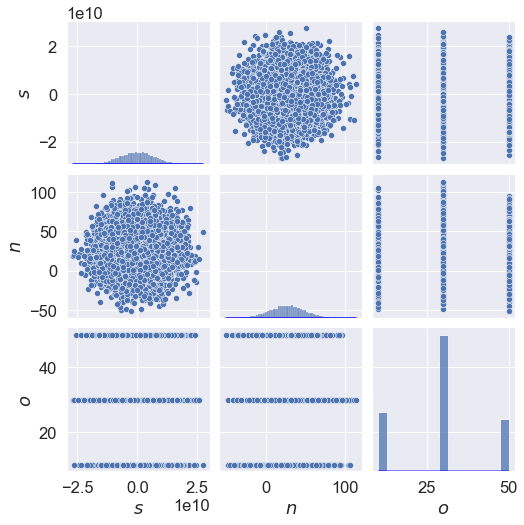

In [56]:
s = st.norm(22.76249168,7409744691).rvs(10_000)
n = st.norm(26.56751279,22.40917218).rvs(10_000)
o = [dp_program_full_opt([si],[ni]) for si, ni in zip(s,n)]
sns.set(font_scale = 1.5)
dist = {"$s$": s, "$n$": n, "$o$": o}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=True, discrete=False, color="blue", stat='density')
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/DP-age-v3.png")

In [ ]:
attacker.parameters.CONT_DIST = 3
wrap7 = attacker.construct_analysis(dp_program_full_opt, 
                            domain, 
                            f,
                            cores=1)

# FBLEAU evaluation

In [138]:
a = st.uniform(0,100).rvs(10_000)
o = a*st.randint(0,1).rvs(1)
trace = {"a": a, "o": o}
fbleau_bayes_risk(trace, "a", "o")

0.0

In [864]:
def bayes_risk_summation(a: List[int]) -> int:
    return sum(a) 

domain = [
    {
        "name": "a",
        "lower": 0,
        "upper": 100,
        "type": "int",
    }
]
def fbleau_bayes_risk(t):
    #Creating datasets
    df=pd.DataFrame(zip(t['Alice_a'],t['out']),columns=['s','o'])
    tr=int(0.8*len(df))
    df_train=df.iloc[:tr]
    df_test=df.iloc[tr:]
    df_test = df_test.drop(df_test[~df_test['s'].isin(df_train['s'])].index)
    
    # Save datasets as csv
    train_data='fbleau_train.csv'
    test_data='fbleau_test.csv'
    df.to_csv('fbleau.csv',header=False,index=False)
    df_train.to_csv(train_data,header=False,index=False)
    df_test.to_csv(test_data,header=False,index=False)
    
    # Execute fbleau
    fbleau_exec='~/.cargo/bin/fbleau'
    cmd=fbleau_exec+' knn --knn-strategy ln '+train_data+' '+test_data
    stdout=subprocess.check_output(cmd, shell=True, text=True)

    return float(re.search('Minimum estimate: (.*)\nMul',stdout).group(1))

fbleau_wrap2 = attacker.construct_analysis(bayes_risk_summation, domain, fbleau_bayes_risk)

100%|██████████| 2/2 [06:40<00:00, 200.17s/it]


In [865]:
fbleau_wrap = fbleau_wrap2
min(fbleau_wrap2.Y[0]), min(fbleau_wrap2.Y[1]), fbleau_wrap2.best_dist()

[ 0. 53.]
Poisson(mu=0.0, scale=53.0)
[36.  1.]
Discrete Uniform(lower=36.0, scale=1.0)


(array([0.]), array([0.]), None)

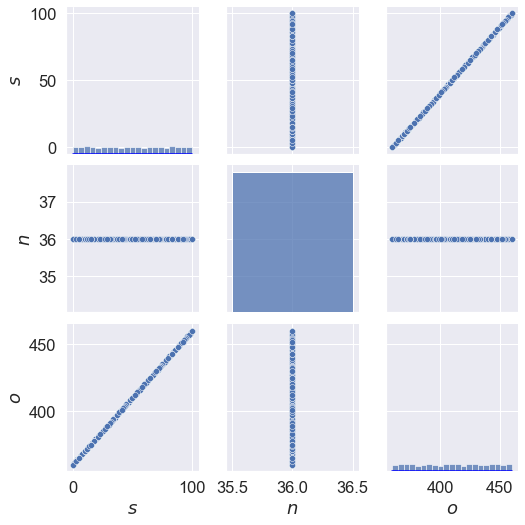

In [866]:
I, trace = fbleau_wrap.functions[1]([fbleau_wrap.X[1][np.argmin(fbleau_wrap.Y[1])]],1, return_trace=True)
sns.set(font_scale = 1.5)
dist = {"$s$": trace["Alice_a"], "$n$": trace["Rest_a"][0], "$o$": trace["out"]}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=True, discrete=True, color="blue", stat='density')
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/FBLEAU_v1.png")

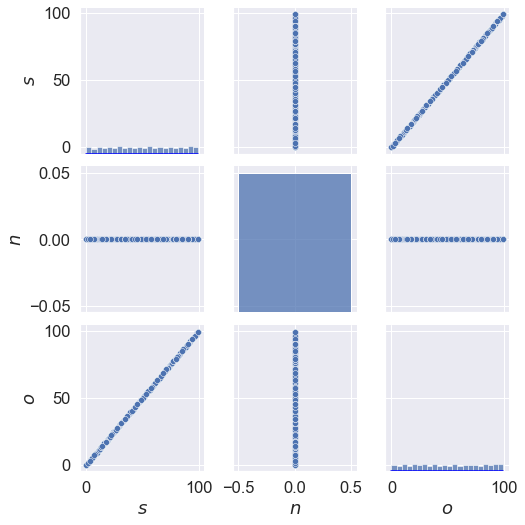

In [380]:
a = st.randint(0,100).rvs(10_000)
b = st.poisson(0,0).rvs(10_000)
o = a+9*b
sns.set(font_scale = 1.5)
dist = {"$s$": a, "$n$": b, "$o$": o}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=True, discrete=True, color="blue", stat='density')
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/FBLEAU_v2.png")

In [374]:
wrap2.best_dist()

[35.06421646  0.1       ]
Normal(mu=35.06421646150887, sigma=0.1)
[44.74614799  1.09555909]
Uniform(lower=44.74614798590257, scale=1.0955590928806096)
[20.2643656  0.1      ]
HalfNormal(mu=20.26436559828507, scale=0.1)


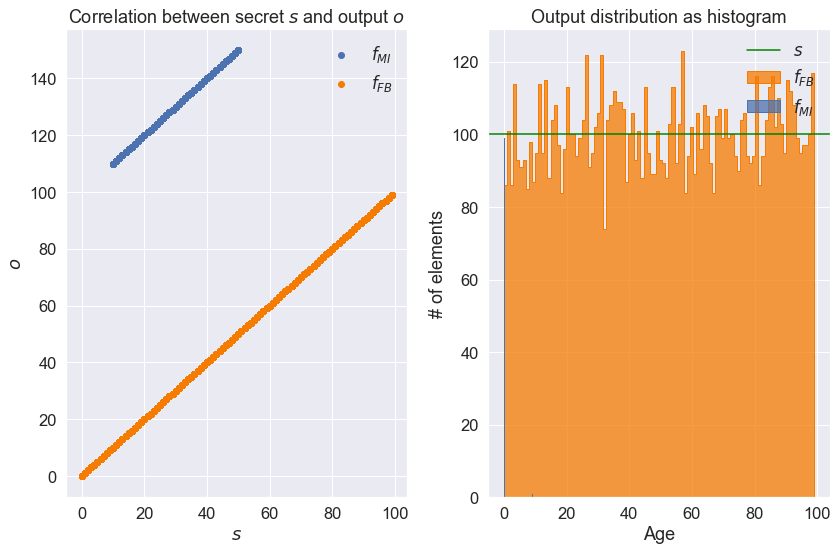

In [439]:
I, trace_MI = wrap2_disc.functions[1]([wrap2_disc.X[1][np.argmin(wrap2_disc.Y[1])]],1, return_trace=True)

fig, ax = plt.subplots(1,2,figsize=(12,8))
ax[0].scatter(trace_MI["Alice_age"], trace_MI["out"], label=r"$f_{MI}$")
ax[0].scatter(a,o, label="$f_{FB}$", color="#f57c00")
ax[0].set_title("Correlation between secret $s$ and output $o$")
ax[0].set_ylabel("$o$")
ax[0].set_xlabel("$s$")

x = np.arange(100)
s,n = st.randint(0,100).pmf(x), st.randint(10,11).pmf(x) 
p = {"$f_{MI}$": s+9*n, "$f_{FB}$": o}
p_prior = {"$s_{MI}$": n, "$s_{FB}$": b}
sns.histplot(o, ax=ax[1], element="step", bins=100, label="$f_{FB}$", color="#f57c00")
sns.histplot(s+9*n, ax=ax[1], element="step", bins=100, label="$f_{MI}$")
ax[1].axhline(100, color="green", label="$s$")
ax[1].set_title("Output distribution as histogram")
ax[1].set_ylabel("# of elements")
ax[1].set_xlabel("Age")

for axs in ax:
    axs.legend()
plt.tight_layout()

plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/Measurement-Comparison.png")

In [633]:
np.corrcoef(trace_MI["Alice_age"], trace_MI["out"])

array([[1., 1.],
       [1., 1.]])

In [202]:
fbleau_wrap.best_dist(), min(fbleau_wrap.Y[0]), min(fbleau_wrap.Y[1])

[0. 0.]
Poisson(mu=0.0, scale=0.0)
[0. 1.]
Discrete Uniform(lower=0.0, scale=1.0)


(None, array([0.3485]), array([0.3625]))

In [842]:
fbleau_wrap.best_dist()

[75.  0.]
Poisson(mu=75.0, scale=0.0)
[18. 72.]
Discrete Uniform(lower=18.0, scale=72.0)


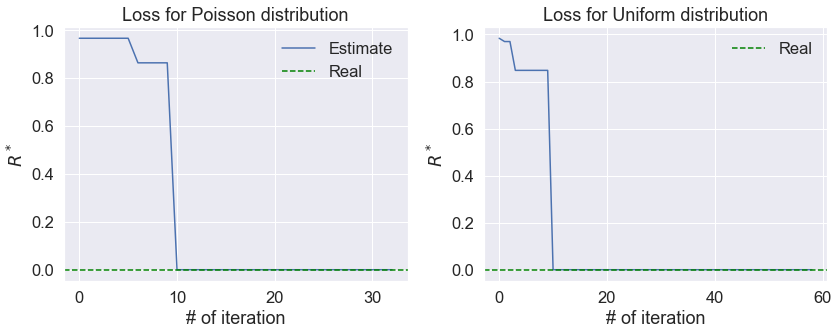

In [871]:
poisson_loss = [min(fbleau_wrap.Y[0][:i]) for i in range(1,len(fbleau_wrap.Y[0]))]
uniform_loss = [min(fbleau_wrap.Y[1][:i]) for i in range(1,len(fbleau_wrap.Y[1]))]



fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(np.arange(len(poisson_loss)), poisson_loss, "-", label="Estimate")
ax[0].set_title("Loss for Poisson distribution")
ax


ax[1].plot(np.arange(len(uniform_loss)), uniform_loss, "-")
ax[1].set_title("Loss for Uniform distribution")


for a in ax:
    a.set_ylabel("$R^*$")
    a.set_xlabel("# of iteration")
    a.axhline(0,linestyle="--", color="green", label="Real")
    a.legend()
plt.tight_layout()
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/FBLEAU_v4.png")

In [267]:
x,y = fbleau_wrap.X, fbleau_wrap.Y
with open("/Users/maoj/Documents/Thesis/Thesis_code/Executions/fbleau.privug", "wb") as fil:
    pickle.dump([x,y], fil)

# Entropy estimate

In [265]:
def identity(a: int) -> int:
    return a

domain = [
    {
        "name": "a",
        "lower": 0,
        "upper": 100,
        "type": "int",
    }
]
def entropy(t):
    s, counts = np.unique(t["a"], return_counts=True)
    counts = counts/len(t["a"])
    return -st.entropy(counts, base=2)

entropy_wrap = attacker.construct_analysis(identity, domain, entropy)


100%|██████████| 2/2 [00:45<00:00, 22.68s/it]


In [347]:
def identity(a: float) -> float:
    return a

domain = [
    {
        "name": "a",
        "lower": 0,
        "upper": 100,
        "type": "float",
    }
]
def entropy_cont(t):
    return -continuous.get_h(t["a"],k=2)

entropy_cont_wrap = attacker.construct_analysis(identity, domain, entropy_cont)


100%|██████████| 3/3 [01:31<00:00, 30.63s/it]


In [348]:
entropy_cont_wrap.best_dist()

[ 71.39266674 833.1677395 ]
Normal(mu=71.3926667398679, sigma=833.1677395030047)
[ 0.37815651 99.29570615]
Uniform(lower=0.37815651051423815, scale=99.29570614712115)
[ 1.11906927 49.44001357]
HalfNormal(mu=1.1190692732692222, scale=49.44001357059641)


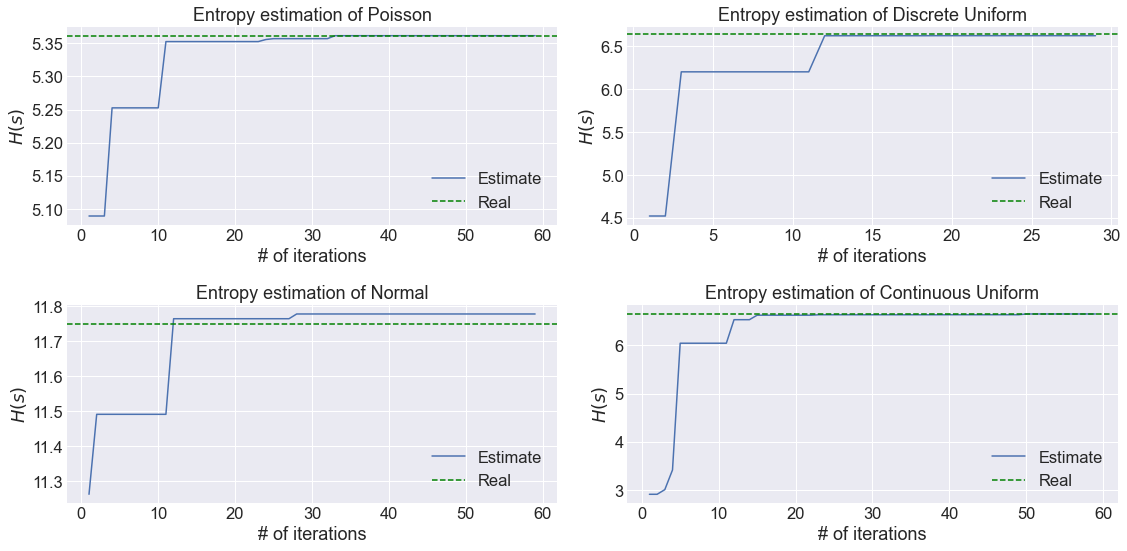

In [356]:
x_pois = np.arange(1,len(entropy_wrap.Y[0]))
x_uni = np.arange(1,len(entropy_wrap.Y[1]))
# continuous
x_normal = np.arange(1,len(entropy_cont_wrap.Y[0]))
x_uni_cont = np.arange(1,len(entropy_cont_wrap.Y[1]))

y_pois = -np.array([min(entropy_wrap.Y[0][:i])[0] for i in range(1,len(x_pois)+1)])
y_uni = -np.array([min(entropy_wrap.Y[1][:i])[0] for i in range(1,len(x_uni)+1)])
#continuous
y_normal = np.log2(np.exp(-np.array([min(entropy_cont_wrap.Y[0][:i]) for i in range(1,len(x_normal)+1)])))
y_uni_cont = np.log2(np.exp(-np.array([min(entropy_cont_wrap.Y[1][:i]) for i in range(1,len(x_uni_cont)+1)])))


fig, ax = plt.subplots(2,2,figsize=(16,8))

ax[0,0].plot(x_pois, y_pois, label="Estimate")
poiss_entropy = np.log2(np.exp(st.poisson(99,1).entropy()))
ax[0,0].axhline(poiss_entropy, linestyle="--", color="green", label="Real")
ax[0,0].set_title("Entropy estimation of Poisson")

ax[0,1].plot(x_uni, y_uni, label="Estimate")
ax[0,1].axhline(np.log2(100), linestyle="--", color="green", label="Real")
ax[0,1].set_title("Entropy estimation of Discrete Uniform")

ax[1,0].plot(x_normal, y_normal, label="Estimate")
normal_entrop = np.log2(np.exp(st.norm(0, 1/12*np.square(100)).entropy()))
ax[1,0].axhline(normal_entrop, linestyle="--", color="green", label="Real")
ax[1,0].set_title("Entropy estimation of Normal")


ax[1,1].plot(x_uni_cont, y_uni_cont, label="Estimate")
ax[1,1].axhline(np.log2(100), linestyle="--", color="green", label="Real")
ax[1,1].set_title("Entropy estimation of Continuous Uniform")


for a in ax:
    for axs in a:
        axs.set_xlabel("# of iterations")
        axs.set_ylabel("$H(s)$")
        axs.legend()
plt.tight_layout()
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/EntropyEstimation.png")

# Consistency

In [458]:
# PPMs

def mean_float(a: List[float]) -> float:
    return np.mean(a)

def sum_float(a: List[float]) -> float:
    return np.sum(a)

def median_float(a: List[float]) -> float:
    return np.median(a)

# Leakage measurements

def mi_float(trace):
    I = mutual_info_regression(trace["Alice_a"].reshape(-1,1), 
                               trace["out"], 
                               discrete_features=False, 
                               random_state=np.random.RandomState(12345))[0]
    return -I

def fbleau_float(trace):
    return fbleau_bayes_risk(trace)

float_domain = [{
        "name": "a",
        "lower": 10,
        "upper": 50,
        "type": "float",
}]

PPMs = [mean_float, sum_float, median_float]

leakage_measurements = [mi_float, fbleau_float]

In [443]:


result = []
backup = []
for ppm in PPMs:
    for lm in leakage_measurements[:1]:
        yerr = []
        b = []
        for _ in range(10):
            w = attacker.construct_analysis(ppm, float_domain, lm)
            best = min(w.Y[0]), min(w.Y[1]), min(w.Y[2])
            yerr.append(best)
            b.append(w)
        result.append(yerr)
        backup.append(b)


100%|██████████| 3/3 [01:46<00:00, 35.54s/it]

100%|██████████| 3/3 [02:49<00:00, 56.54s/it]

100%|██████████| 3/3 [02:28<00:00, 49.65s/it]

100%|██████████| 3/3 [01:48<00:00, 36.04s/it]

100%|██████████| 3/3 [01:53<00:00, 37.79s/it]

  0%|          | 0/2 [12:13:45<?, ?it/s]s/it]

100%|██████████| 3/3 [02:48<00:00, 56.03s/it]


In [454]:
yerr

[(array([-1.05880907]), array([-0.3173266]), array([-0.22807732])),
 (array([-1.09217433]), array([-0.31428258]), array([-0.23079069])),
 (array([-1.05275262]), array([-0.29749681]), array([-0.22834458])),
 (array([-1.0753651]), array([-0.32200152]), array([-0.23519511])),
 (array([-1.05433635]), array([-0.30223136]), array([-0.23886146])),
 (array([-1.09511889]), array([-0.31279063]), array([-0.24282937])),
 (array([-1.07248058]), array([-0.30545089]), array([-0.23539965])),
 (array([-1.04014635]), array([-0.3172461]), array([-0.13316245])),
 (array([-1.05206248]), array([-0.2987763]), array([-0.23526336])),
 (array([-1.06926637]), array([-0.28904395]), array([-0.24506439]))]

In [459]:
for ppm in PPMs:
    for lm in leakage_measurements[1:]:
        yerr = []
        b = []
        for _ in range(10):
            w = attacker.construct_analysis(ppm, float_domain, lm)
            best = min(w.Y[0]), min(w.Y[1]), min(w.Y[2])
            yerr.append(best)
            b.append(w)
        result.append(yerr)
        backup.append(b)



  0%|          | 0/3 [00:49<?, ?it/s]


 33%|███▎      | 1/3 [00:50<01:41, 50.61s/it]

 67%|██████▋   | 2/3 [01:49<00:55, 55.73s/it]

100%|██████████| 3/3 [03:42<00:00, 74.01s/it]


In [557]:
values = np.array(result)
normals = values[:,:,0]
uniforms = values[:,:,1]
half_normals = values[:,:,2]

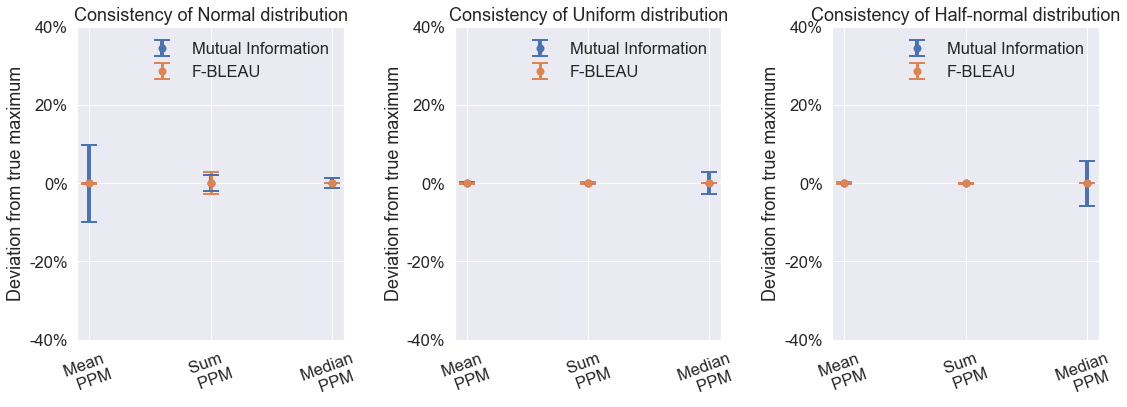

In [593]:
def error(ax, n):
    yerr = np.sqrt((n.reshape(6,10) - np.median(n, axis=1).reshape(-1,1))**2).mean(axis=1)
    x = np.arange(3)
    best = np.min(n, axis=1).flatten()
    ax.errorbar(x, [0]*len(x), yerr=yerr[:3]/best[:3], 
                fmt="o", 
                label="Mutual Information",
                capsize=8, 
                elinewidth=4,
                markeredgewidth=2)
    ax.errorbar(x, [0]*len(x), yerr=yerr[3:]/1, fmt="o", 
                label="F-BLEAU",
                capsize=8, 
                elinewidth=3,
                markeredgewidth=2)
    ax.set_xticks(x)
    ax.set_xticklabels(["Mean \n PPM", "Sum \n PPM", "Median \n PPM"], rotation=20)
    ax.set_ylim(-.4,.4)
    ax.set_yticks([-.4,-.2, 0, .2, .4])
    ax.set_yticklabels(["-40%","-20%", "0%","20%", "40%"])
    ax.set_ylabel("Deviation from true maximum")

fig,ax = plt.subplots(1,3, figsize=(16,6))
error(ax[0],normals)
error(ax[1], uniforms)
error(ax[2], half_normals)

ax[0].set_title("Consistency of Normal distribution")
ax[1].set_title("Consistency of Uniform distribution")
ax[2].set_title("Consistency of Half-normal distribution")
for axs in ax:
    axs.legend()

plt.tight_layout()
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/Consistency-comparison.png")

# K-Annonymity

In [739]:
def kanonAge(age: List[float]) -> int:
    return np.mean(kanon(age))

domain = [
    {
        "name": "age",
        "lower": 10,
        "upper": 50,
        "type": "float",
    }
]
def mi(t):
    return -mutual_info_regression(t["Alice_age"].reshape(-1,1), 
                                   t["out"], 
                                   discrete_features=False)[0]

Kanon_Wrap = attacker.construct_analysis(kanonAge, domain, mi)



  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:50<01:41, 50.62s/it]

 67%|██████▋   | 2/3 [02:01<01:02, 62.26s/it]

100%|██████████| 3/3 [03:03<00:00, 61.12s/it]


In [740]:
np.min(Kanon_Wrap.Y, axis=1)

array([[-1.38620997],
       [-1.38623019],
       [-1.38630447]])

In [741]:
Kanon_Wrap.best_dist()

[19.08922263  0.1       ]
Normal(mu=19.089222632379, sigma=0.1)
[15.331907    1.09581317]
Uniform(lower=15.331906995862184, scale=1.0958131739575905)
[42.54801929  0.1       ]
HalfNormal(mu=42.54801928981807, scale=0.1)


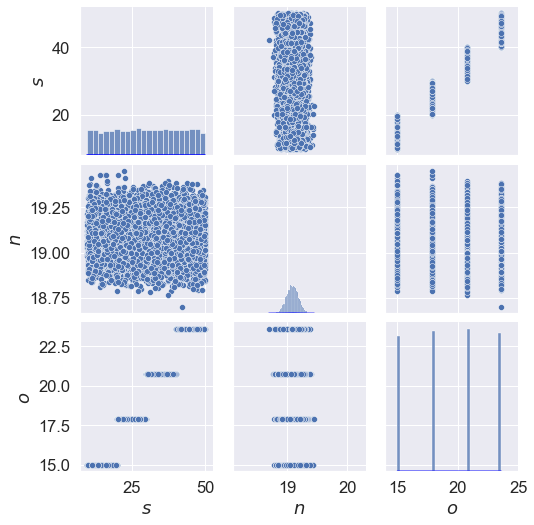

In [743]:
I, trace = Kanon_Wrap.functions[0]([Kanon_Wrap.X[0][np.argmin(Kanon_Wrap.Y[0])]],0, return_trace=True)
sns.set(font_scale = 1.5)
dist = {"$s$": trace["Alice_age"], "$n$": trace["Rest_age"][0], "$o$": trace["out"]}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=True, discrete=True, color="blue", stat='density')
plt.savefig("/Users/maoj/Documents/Thesis/Thesis_code/img/Kanon_Age-v1.png")

In [744]:
np.corrcoef(trace["Alice_age"], trace["out"])

array([[1.      , 0.967751],
       [0.967751, 1.      ]])

In [708]:
from crowds.kanonymity import ola
from crowds.kanonymity.generalizations import GenRule
from crowds.kanonymity.information_loss import dm_star_loss

In [639]:
t = pd.DataFrame({"age": [10,12,10,12,14,10]})

In [733]:
def generalize_age(age):
    if 10 <= age < 20:
        return 15
    if 20 <= age < 30:
        return 25
    if 30 <= age < 40:
        return 35
    if 40 <= age <= 50:
        return 45
    else:
        return 0
    
def kanon(age, k=4, outcome=[15,25,35,45, 0]):
    out = [generalize_age(a) for a in age]
    for i in outcome:
        co = out.count(i)
        if 0 < co < k:
            for _ in range(co, k):
                out.append(i)
    return out

In [695]:
def generalize_age2(age):
    if 10 <= age < 20:
        return "15"
    elif 20 <= age < 30:
        return "25"
    elif 30 <= age < 40:
        return "35"
    else:
        return "45"

generalization_rules2 = {
    'age': GenRule([generalize_age2]) # 2-levels generalization
}
t = pd.DataFrame({"age": [10,40,20,30,12], "height": [100,120,200,180,183]})
ola.anonymize(t, generalization_rules=generalization_rules2, k=2, max_sup=0.5)

[       age         workClass  fnlwgt     education  education-num  \
 0       39         State-gov   77516     Bachelors             13   
 1       39           Private  367260       HS-grad              9   
 2       39           Private  365739  Some-college             10   
 3       39       Federal-gov  235485    Assoc-acdm             12   
 4       39               NaN  157443       Masters             14   
 ...    ...               ...     ...           ...            ...   
 32554   84           Private  188328       HS-grad              9   
 32555   84           Private  388384       7th-8th              4   
 32556   85           Private  115364       HS-grad              9   
 32557   85  Self-emp-not-inc  166027       HS-grad              9   
 32558   85           Private   98611     Bachelors             13   
 
            marital-status       occupation   relationship                race  \
 0           Never-married     Adm-clerical  Not-in-family               Whi

Perhaps if running differential private with a program leakage is smaller

In [796]:
n

AttributeError: module 'numpy' has no attribute 'comb'

In [819]:
x = np.arange(0,20)
a = st.randint.pmf(x, 0,100)
b = st.randint.pmf(x,0,100)
def bayes_risk(u1,u2):
    s = np.arange(0,u2)
    test = []
    for t in range(u1+u2):
        val = 0
        for i in range(u1):
            if t in i+s:
                val += 1
        test.append(val)
    test = np.array(test)
    return test
test = bayes_risk(5,1)
max(test/sum(test))
#res = np.array([i+1 for i in range(100)] + [i+1 for i in range(100)][::-1])
#max(res/sum(res))

0.2

In [820]:
[st.randint.pmf(10-i,0,10) for i in range(0,10)]

[0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [863]:
a = st.randint(0,100).rvs(10_000)
b = st.randint(0,4).rvs(10_000)
t = {"Alice_a": a, "out": a+b}
fbleau_bayes_risk(t)

-0.721

In [828]:
sum_disc_uniforms(0,50,50)

0.0004

In [855]:
def sum_disc_uniforms(z,n,m):
    return sum([st.randint.pmf(i,0,n)*st.randint.pmf(z-i,0,m) for i in range(0,n)])

1-sum_disc_uniforms(100,100,100)

0.9901

In [888]:
def Location(loc: List[Tuple[float, float]]) -> float:
    print(loc)
    return 10
domain = [
    {
        "name": "loc",
        "lower": 0,
        "upper": 100,
        "type": "float",
    }
]
def mi_loc(t):
    return -mutual_info_regression(t["Alice_loc"].reshape(-1,1), 
                                   t["out"], 
                                   discrete_features=False)[0]

locWrap = attacker.construct_analysis(Location, domain, mi_loc)

  0%|          | 0/3 [00:00<?, ?it/s]

IndexError: list index out of range